In [34]:
#importing relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import statistics
%matplotlib inline

In [35]:
#dictionary with parish names as keys and device ids as values
parish_sensor_dict = {'NTINDA':930434, 'BUGOLOBI':718028, 'NANTABULIRWA':912224, 'KIREKA':930426, 'LUWAFU':930427, 
                     'BANDA':912223, 'MBUYA II':912222, 'NAKASERO II':912220, 'KIWATULE':870145, 'KYALIWAJJALA':870143,
                     'BUTABIKA':870144, 'NANSANA WEST':870147, 'NANSANA EAST':870142, 'BUSEGA':870139, 'KYANJA':832255,
                     'BUSABALA':832252, 'BUNAMWAYA':832253, 'KYEBANDO':832254, 'LUKULI':832251, 'BUKOTO I':782720,
                     'KANSANGA':782719, 'KASUBI':782718, 'NAGURU II':755614, 'MAKINDYE I':755612,
                     'MAKERERE UNIVERSITY':870146, 'LUBAGA':737276, 'BWEYOGERERE':737273, 'CIVIC CENTRE':689761}

In [36]:
def preprocessing(parish):
    '''
    Collects and preprocesses air quality data for a particular parish
    '''
    channel_id = parish_sensor_dict[parish]
    
    filepath = r'D:/AirQo/sensor location model/feeds/'+str(channel_id)+'.csv'
    cols = ['created_at', 'field1']
    parish_data = pd.read_csv(filepath,  parse_dates = ['created_at'], usecols=cols)
    
    parish_data.set_index('created_at', inplace=True)
    hourly_data = parish_data.resample('H').mean().round(2)  
    final_data=hourly_data.dropna()
    
    name = parish+'_pm2_5'
    final_data.rename(columns = {'field1': name}, inplace = True)
    
    return final_data

In [37]:
def merge_dfs(df_list):
    '''
    Merges several dataframes into one based on the index
    '''
    from functools import reduce
    final_df = reduce(lambda left,right: pd.merge(left,right,on='created_at'), df_list)
    return final_df

In [38]:
def correlation_matrix_1(df):
    return df.corr()

In [39]:
def correlation_matrix_2(df, title):
    '''
    plots correlation matrix for dataframe
    '''
    import seaborn as sns
    
    plt.figure(figsize=(10,10))
    plt.title(title)
    sns.heatmap(correlation_matrix_1(df), annot=True, cmap=plt.cm.Reds)
    plt.show()

In [40]:
def generate_matrix(data, title):
    df_list = []
    for parish in data.parish:
        parish_data= preprocessing(parish)
        df_list.append(parish_data)
    merged_df = merge_dfs(df_list)
    correlation_matrix_2(merged_df, title)

In [41]:
def standard_scaling(X):
    columns = X.columns
    X_scaled = StandardScaler().fit_transform(X)
    X_df = pd.DataFrame(X_scaled)
    X_df.columns = columns
    #X_df['coord_x'] = np.cos(X_df['lat']) * np.cos(X_df['long'])
    #X_df['coord_y'] = np.cos(X_df['lat']) * np.sin(X_df['long'])
    #X_df['coord_z'] = np.sin(X_df['lat'])
    #X_df =X_df.drop(['lat', 'long'], axis = 1)
    return X_df

In [42]:
def mean_and_median(correlation_list):
    print ('Median correlation is %f' %statistics.median(correlation_list))
    print ('Average correlation is %f' %statistics.mean(correlation_list))

In [43]:
#Loading geo_census data
file = 'gp_data.csv'
data = pd.read_csv(file)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z,cluster,average pm2_5,category
0,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),0.266405,0.906592,0.327290,13,33.419091,Moderate
1,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),0.328582,0.872929,0.360595,5,62.826075,Unhealthy
2,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),0.338856,0.877348,0.339761,13,52.140047,Unhealthy for Sensitive Groups
3,KAMPALA,NAKAWA DIVISION,BUKOTO I,23045,6386,30.8,32.596444,0.352933,2.097909,2.079645,...,0.15,0.12,"POLYGON((32.606305670664 0.351686206757447, 32...",POINT(32.5964437591639 0.352933214544676),0.356997,0.867801,0.345652,7,61.987713,Unhealthy
4,KAMPALA,NAKAWA DIVISION,BUGOLOBI,5023,1279,23.6,32.622657,0.311176,3.912260,3.877850,...,0.61,0.41,"POLYGON((32.6366037654667 0.30743072901818, 32...",POINT(32.6226571504019 0.311175541587068),0.338976,0.889579,0.306178,13,44.273017,Unhealthy for Sensitive Groups


In [44]:
columns_to_drop = ['coord_x', 'coord_y', 'coord_z', 'cluster', 'average pm2_5', 'category']
data.drop(columns = columns_to_drop, inplace=True)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
1,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
2,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)
3,KAMPALA,NAKAWA DIVISION,BUKOTO I,23045,6386,30.8,32.596444,0.352933,2.097909,2.079645,...,1328.94,10984.75,3043.98,3.61,16.78,13.40,0.15,0.12,"POLYGON((32.606305670664 0.351686206757447, 32...",POINT(32.5964437591639 0.352933214544676)
4,KAMPALA,NAKAWA DIVISION,BUGOLOBI,5023,1279,23.6,32.622657,0.311176,3.912260,3.877850,...,22.49,1283.91,326.92,3.93,7.90,5.25,0.61,0.41,"POLYGON((32.6366037654667 0.30743072901818, 32...",POINT(32.6226571504019 0.311175541587068)


##### using two features

c:\users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


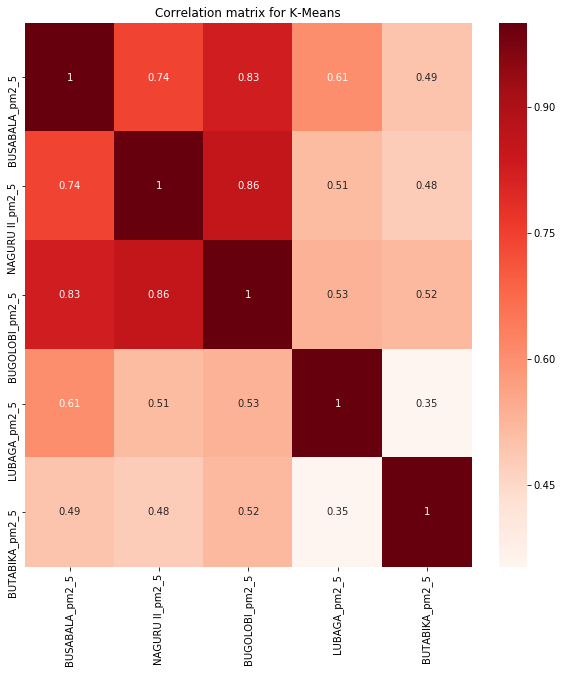

In [45]:
two_features = data[['lat', 'long']]
two_features_scaled = standard_scaling(two_features)
kmeans = KMeans(n_clusters = 5).fit(two_features_scaled) 
y_kmeans = kmeans.fit_predict(two_features_scaled)

data['cluster'] = y_kmeans

kmeans_samples = data.sample(frac=1).reset_index(drop=True)
kmeans_samples= kmeans_samples.drop_duplicates('cluster', keep = 'last')
generate_matrix(kmeans_samples, 'Correlation matrix for K-Means using two features')

In [ ]:
two_features_list =[0.62, 0.69, 0.66, 0.67, 0.75, 0.74, 0.69, 0.95, 0.82, 0.84]
mean_and_median(two_features_list)

##### using four features

In [ ]:
four_features = data[['lat', 'long', 'pop_density', 'hhs_density']]
four_features_scaled = standard_scaling(four_features)
kmeans = KMeans(n_clusters = 5).fit(four_features_scaled) 
y_kmeans = kmeans.fit_predict(four_features_scaled)

data['cluster'] = y_kmeans

kmeans_samples = data.sample(frac=1).reset_index(drop=True)
kmeans_samples= kmeans_samples.drop_duplicates('cluster', keep = 'last')
generate_matrix(kmeans_samples, 'Correlation matrix for K-Means using four features')

In [ ]:
four_features_list =[]
mean_and_median(four_features_list)

##### using six features

In [ ]:
fo_features = data[['lat', 'long', 'pop_density', 'hhs_density', 'waste_burn_per_km', 'T123_per_sqkm']]
four_features_scaled = standard_scaling(four_features)
kmeans = KMeans(n_clusters = 5).fit(four_features_scaled) 
y_kmeans = kmeans.fit_predict(four_features_scaled)

data['cluster'] = y_kmeans

kmeans_samples = data.sample(frac=1).reset_index(drop=True)
kmeans_samples= kmeans_samples.drop_duplicates('cluster', keep = 'last')
generate_matrix(kmeans_samples, 'Correlation matrix for K-Means using six features')

##### using most features


In [12]:
X = data[['lat', 'long','light_par_tadooba_per_km', 'light_firewood_per_km', 'light_cow_dung_per_km', 'light_grass_per_km', 
          'cook_charc_per_km', 'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km', 'waste_burn_per_km',
          'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 
          'hhs_density', 'T123_per_sqkm']]
X_scaled = standard_scaling(X)
kmeans = KMeans(n_clusters = 5).fit(X_scaled) 
y_kmeans = kmeans.fit_predict(X_scaled)
y_kmeans

array([1, 2, 1, 4, 1, 2, 2, 3, 4, 4, 4, 3, 4, 1, 1, 1, 2, 0, 0, 4, 4, 4,
       3, 4, 2, 0, 2, 3])

In [13]:
data['cluster'] = y_kmeans
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,cluster
0,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),1
1,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),2
2,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),1
3,KAMPALA,NAKAWA DIVISION,BUKOTO I,23045,6386,30.8,32.596444,0.352933,2.097909,2.079645,...,10984.75,3043.98,3.61,16.78,13.40,0.15,0.12,"POLYGON((32.606305670664 0.351686206757447, 32...",POINT(32.5964437591639 0.352933214544676),4
4,KAMPALA,NAKAWA DIVISION,BUGOLOBI,5023,1279,23.6,32.622657,0.311176,3.912260,3.877850,...,1283.91,326.92,3.93,7.90,5.25,0.61,0.41,"POLYGON((32.6366037654667 0.30743072901818, 32...",POINT(32.6226571504019 0.311175541587068),1


In [14]:
kmeans_samples = data.sample(frac=1).reset_index(drop=True)
kmeans_samples= kmeans_samples.drop_duplicates('cluster', keep = 'last')
kmeans_samples

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,cluster
10,KAMPALA,KAWEMPE DIVISION,KYEBANDO,44552,11907,27.7,32.580218,0.357728,3.119204,3.092221,...,14283.13,3817.32,3.74,19.49,11.28,0.14,0.08,"POLYGON((32.5886007059737 0.357883201060667, 3...",POINT(32.5802181882541 0.357728183733192),3
19,KAMPALA,NAKAWA DIVISION,BUKOTO I,23045,6386,30.8,32.596444,0.352933,2.097909,2.079645,...,10984.75,3043.98,3.61,16.78,13.40,0.15,0.12,"POLYGON((32.606305670664 0.351686206757447, 32...",POINT(32.5964437591639 0.352933214544676),4
21,WAKISO,NANSANA DIVISION,NANSANA EAST,27768,6898,29.1,32.530586,0.367282,2.654985,2.632465,...,10458.82,2598.13,4.03,22.62,13.64,0.22,0.13,"POLYGON((32.5331574923712 0.372837835675488, 3...",POINT(32.5305858106101 0.367282136283768),0
25,WAKISO,NAMUGONGO DIVISION,KYALIWAJJALA,51921,12646,25.0,32.655741,0.384000,12.251303,12.142153,...,4238.00,1032.22,4.11,10.71,8.78,0.25,0.21,"POLYGON((32.6745814286776 0.393191752252496, 3...",POINT(32.655740993007 0.383999891373294),2
27,KAMPALA,KAWEMPE DIVISION,MAKERERE UNIVERSITY,5641,637,33.6,32.566174,0.334154,1.746998,1.731969,...,3228.97,364.63,8.86,18.42,14.86,0.57,0.46,"POLYGON((32.5719298266151 0.338111773598847, 3...",POINT(32.5661742053799 0.334153901935297),1


In [15]:
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,cluster
0,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),1
1,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),2
2,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),1
3,KAMPALA,NAKAWA DIVISION,BUKOTO I,23045,6386,30.8,32.596444,0.352933,2.097909,2.079645,...,10984.75,3043.98,3.61,16.78,13.40,0.15,0.12,"POLYGON((32.606305670664 0.351686206757447, 32...",POINT(32.5964437591639 0.352933214544676),4
4,KAMPALA,NAKAWA DIVISION,BUGOLOBI,5023,1279,23.6,32.622657,0.311176,3.912260,3.877850,...,1283.91,326.92,3.93,7.90,5.25,0.61,0.41,"POLYGON((32.6366037654667 0.30743072901818, 32...",POINT(32.6226571504019 0.311175541587068),1


c:\users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


KYEBANDO :done
BUKOTO I :done
NANSANA EAST :done
KYALIWAJJALA :done
MAKERERE UNIVERSITY :done


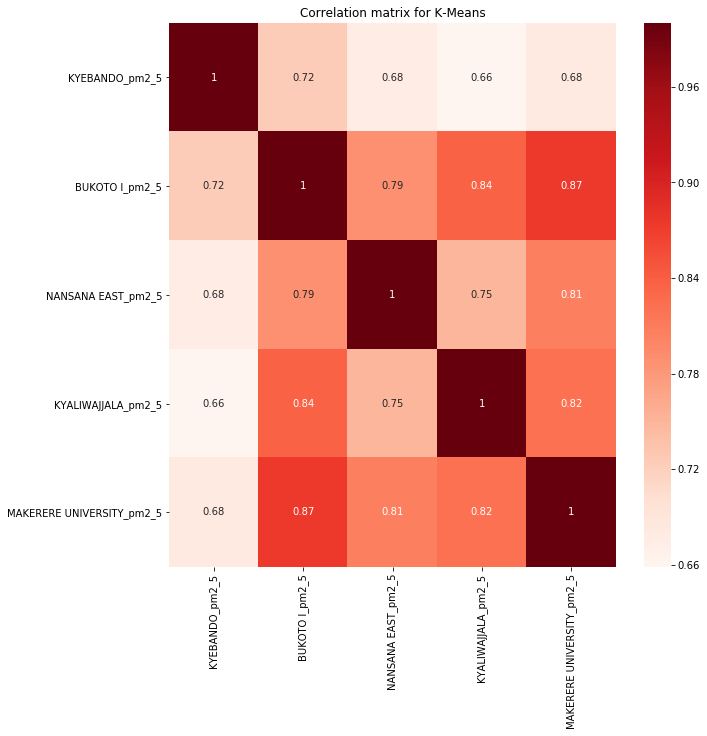

In [16]:
#getting the air quality data for each parish from a different cluster
generate_matrix(kmeans_samples, 'Correlation matrix for K-Means')

In [33]:
most_features_list =[0.72, 0.68, 0.66, 0.68, 0.79, 0.84, 0.87, 0.75, 0.81, 0.82]
mean_and_median(most_features_list)

Median correlation is 0.770000
Average correlation is 0.762000


### Correlation matrices between parishes in the same cluster

In [17]:
cluster1 = data.loc[data['cluster'] == 1]
cluster2 = data.loc[data['cluster'] == 2]
cluster3 = data.loc[data['cluster'] == 3]
cluster4 = data.loc[data['cluster'] == 4]
cluster0 = data.loc[data['cluster'] == 0]

NANSANA WEST :done
NANSANA EAST :done
KIREKA :done


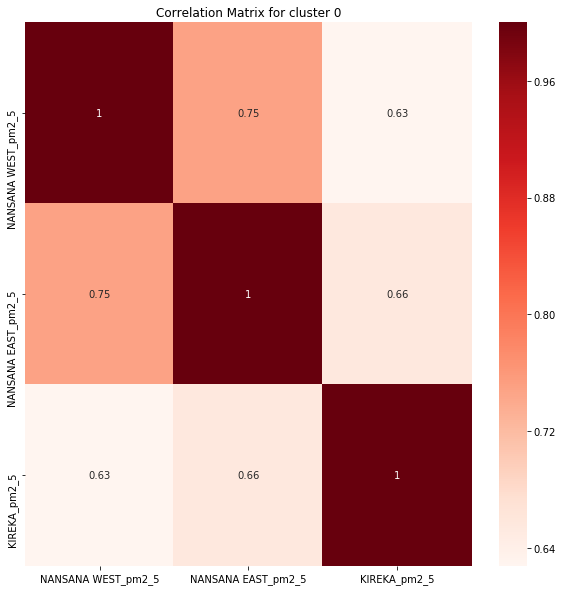

NANTABULIRWA :done
NTINDA :done
BUGOLOBI :done
NAKASERO II :done
CIVIC CENTRE :done
MAKERERE UNIVERSITY :done


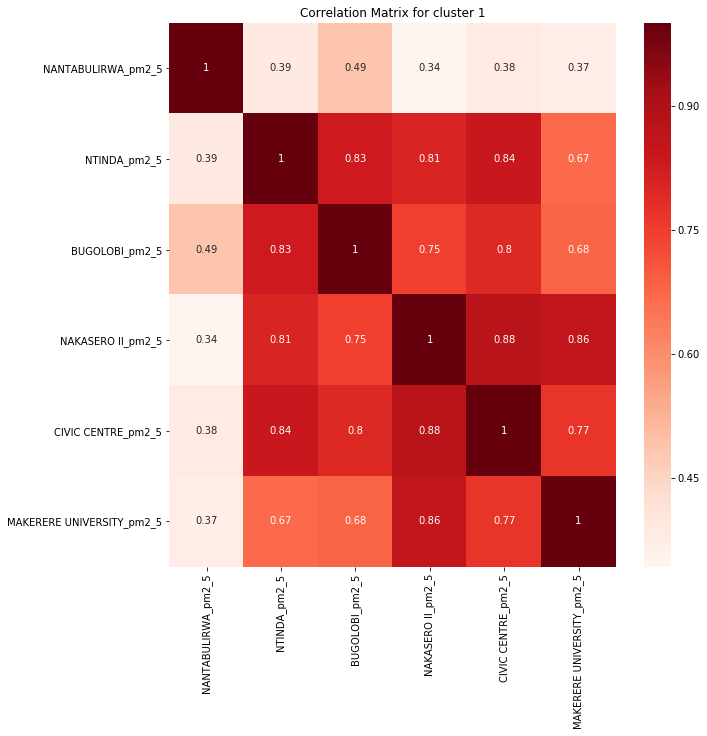

KIWATULE :done
BUTABIKA :done
KYANJA :done
BUSABALA :done
KYALIWAJJALA :done
BWEYOGERERE :done


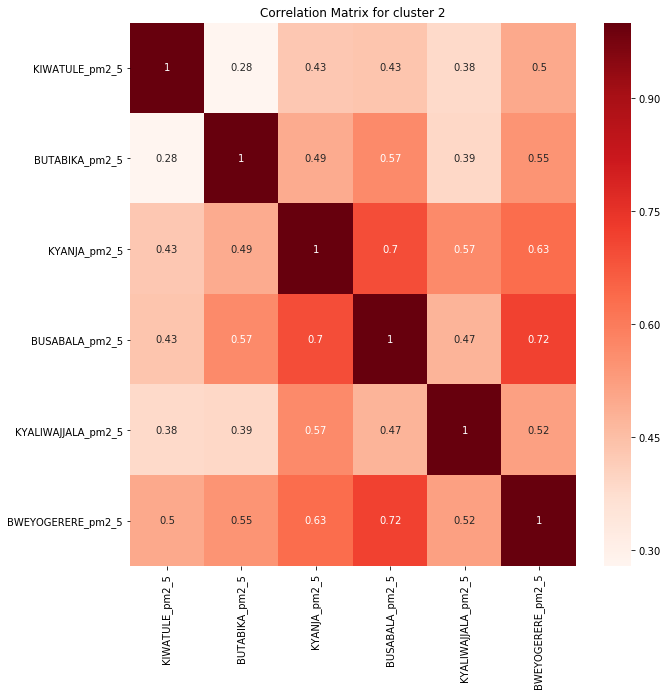

BANDA :done
KASUBI :done
MAKINDYE I :done
KYEBANDO :done


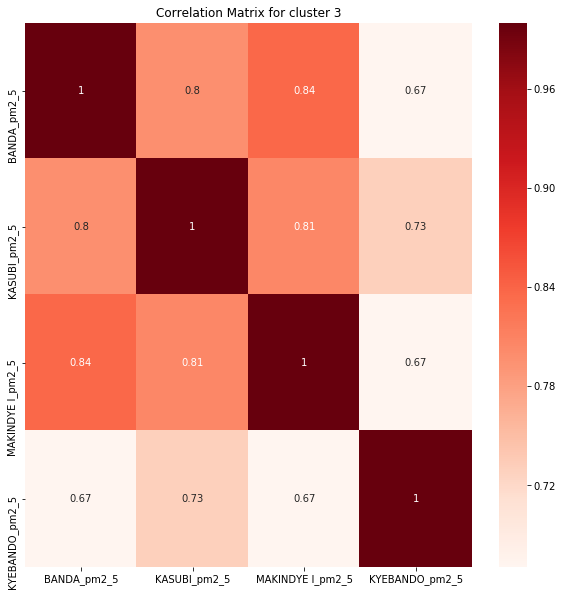

BUKOTO I :done
MBUYA II :done
NAGURU II :done
BUSEGA :done
LUBAGA :done
LUKULI :done
LUWAFU :done
KANSANGA :done
BUNAMWAYA :done


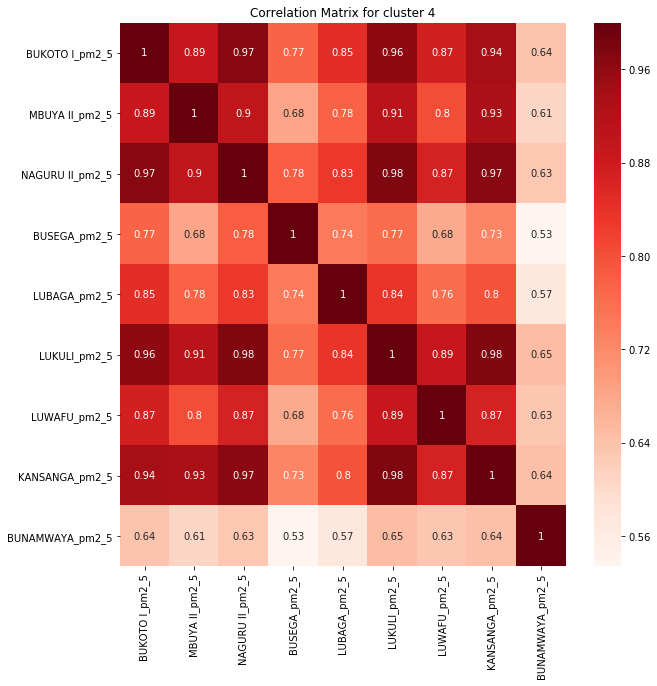

In [18]:
cluster_list = [cluster0, cluster1, cluster2, cluster3, cluster4]
count = 0
for cluster in cluster_list:
    title = 'Correlation Matrix for cluster %d' %count
    generate_matrix(cluster, title)
    count+=1

##### using 10 features

In [19]:
ten_features = data[['lat', 'long', 'cook_charc_per_km', 'cook_firewood_per_km', 'waste_burn_per_km', 
                        'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 
                        'pop_density', 'hhs_density']]
ten_features_scaled = standard_scaling(ten_features)
kmeans = KMeans(n_clusters = 5).fit(ten_features_scaled) 
y_kmeans = kmeans.fit_predict(ten_features_scaled)
y_kmeans

array([2, 4, 2, 4, 2, 4, 4, 3, 4, 4, 0, 3, 1, 2, 2, 2, 1, 0, 0, 1, 0, 1,
       3, 1, 4, 0, 4, 3])

In [20]:
data['cluster'] = y_kmeans
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,cluster
0,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),2
1,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),4
2,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),2
3,KAMPALA,NAKAWA DIVISION,BUKOTO I,23045,6386,30.8,32.596444,0.352933,2.097909,2.079645,...,10984.75,3043.98,3.61,16.78,13.40,0.15,0.12,"POLYGON((32.606305670664 0.351686206757447, 32...",POINT(32.5964437591639 0.352933214544676),4
4,KAMPALA,NAKAWA DIVISION,BUGOLOBI,5023,1279,23.6,32.622657,0.311176,3.912260,3.877850,...,1283.91,326.92,3.93,7.90,5.25,0.61,0.41,"POLYGON((32.6366037654667 0.30743072901818, 32...",POINT(32.6226571504019 0.311175541587068),2


c:\users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


BANDA :done
KYALIWAJJALA :done
NAKASERO II :done
LUWAFU :done
KANSANGA :done


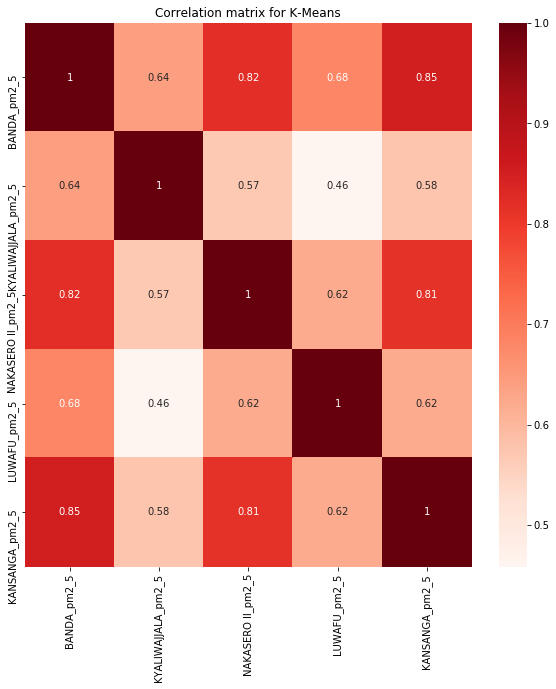

In [21]:
kmeans_samples = data.sample(frac=1).reset_index(drop=True)
kmeans_samples= kmeans_samples.drop_duplicates('cluster', keep = 'last')
generate_matrix(kmeans_samples, 'Correlation matrix for K-Means')

In [32]:
ten_features_list =[0.64, 0.82, 0.68, 0.85, 0.57, 0.46, 0.58, 0.62, 0.81, 0.62]
mean_and_median(ten_features_list)

Median correlation is 0.630000
Average correlation is 0.665000


###### using 8 features

c:\users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


MAKINDYE I :done
KYANJA :done
NANTABULIRWA :done
KANSANGA :done
LUWAFU :done


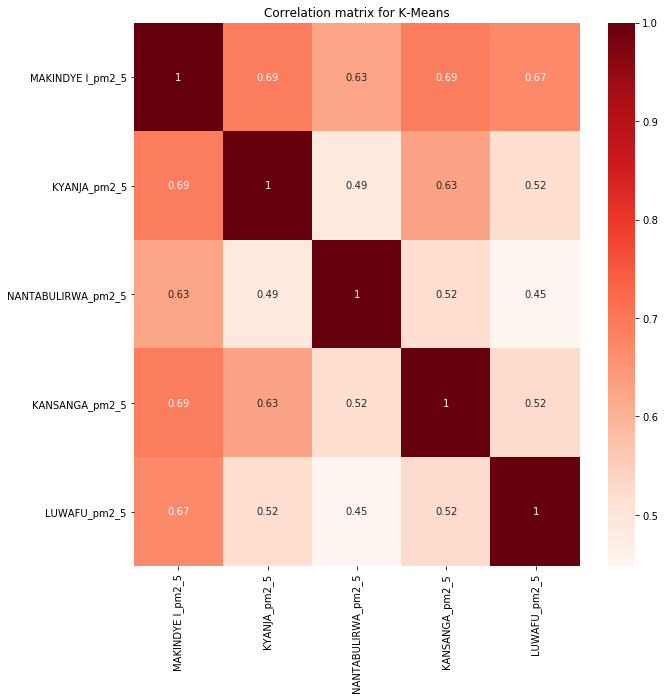

In [22]:
eight_features = data[['lat', 'long','kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'cook_firewood_per_km', 
                      'cook_charc_per_km', 'waste_burn_per_km','pop_density']]
eight_features_scaled = standard_scaling(eight_features)
kmeans = KMeans(n_clusters = 5).fit(eight_features_scaled) 
y_kmeans = kmeans.fit_predict(eight_features_scaled)

data['cluster'] = y_kmeans

kmeans_samples = data.sample(frac=1).reset_index(drop=True)
kmeans_samples= kmeans_samples.drop_duplicates('cluster', keep = 'last')
generate_matrix(kmeans_samples, 'Correlation matrix for K-Means')

In [31]:
eight_features_list =[0.69, 0.63, 0.69, 0.67, 0.49, 0.63, 0.52, 0.52, 0.45, 0.52]
mean_and_median(eight_features_list)

Median correlation is 0.575000
Average correlation is 0.581000


##### using only latitude and longitude coordinates

c:\users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


BUSABALA :done
KIREKA :done
CIVIC CENTRE :done
BUKOTO I :done
MAKERERE UNIVERSITY :done


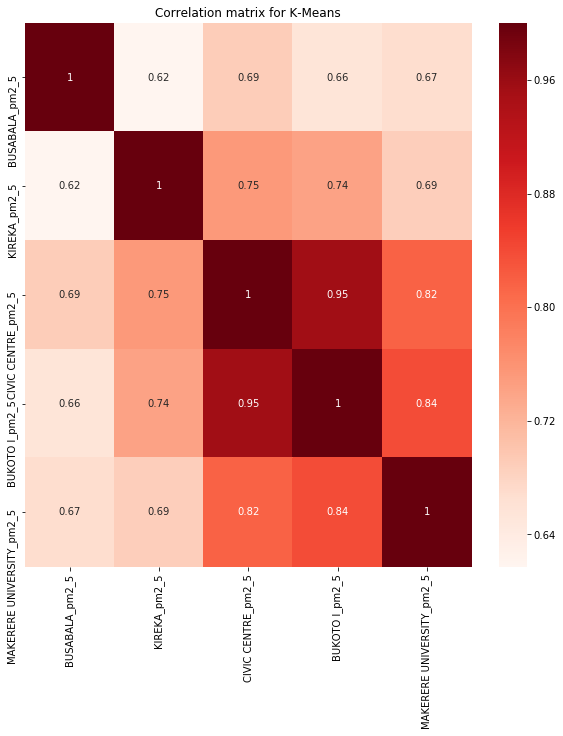

Median correlation is 0.715000
Average correlation is 0.743000


### Silhouette Analysis

In [190]:
def silhouette(data):
    '''
    determines optimal number of clusters using silhouette analysis
    '''
    from sklearn.metrics import silhouette_samples, silhouette_score
    silhouette_avgs = {}
    n_clusters = [x for x in range(2,27)]
    for n_clusters in n_clusters:

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_avgs[n_clusters] = silhouette_avg
    key_max = max(silhouette_avgs.keys(), key=(lambda k: silhouette_avgs[k]))
    print('Best silhoutte score is %f for %d clusters' %(silhouette_avgs[key_max], key_max))

In [191]:
silhouette(data)

Best silhoutte score is 0.590909 for 2


In [192]:
silhouette(X)

Best silhoutte score is 0.590909 for 2


In [193]:
silhouette(ten_features)

Best silhoutte score is 0.590909 for 2
